# Churn Prediction Analysis

## Objective
The goal of this notebook is to **identify customers who are likely to stop purchasing (churn)** and understand the key factors that drives churn behavior. Predicting churn helps businesses take **proactive retention actions** and protect future revenue.

## Approach
- Aggregate transaction data at the **customer level**
- Define churn based on **purchase inactivity (180 days)**
- Engineer behavioral and service-related features
- Train and computer **Logistic Regression** and **Random Forest** models
- Evaluate models using **classification metrics and ROC-AUC**
- Estimate **churn probability** and classify customers into risk groups

In [2]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# loading data
print("\n===== LOADING DATA =====")

master_df = pd.read_csv("OneDrive/Documents/Customer Sales Analytics/master_table_processed.csv")
master_df["order_purchase_timestamp"] = pd.to_datetime(master_df["order_purchase_timestamp"])

print(f"Orders loaded: {len(master_df):,}")


===== LOADING DATA =====
Orders loaded: 96,478


In [5]:
master_df.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_month,order_day_of_week,is_weeknd,year_month,avg_item_price,freight_percentage,satisfaction_score,is_weekend,is_extreme_delay,delivery_time_days_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,10,0,0,2017-10,29.99,22.526479,4.0,0,0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,7,1,0,2018-07,118.70,16.089354,4.0,0,0,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,8,2,0,2018-08,159.90,10.730237,5.0,0,0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,11,5,1,2017-11,45.00,37.673130,5.0,1,0,13.0


# Define Churn at Customer Level

In [6]:
# customer-level aggregation
print("\n===== DEFINING CHURN =====")

# get last order date (cutoff for analysis)
analysis_date = master_df["order_purchase_timestamp"].max()
print(f"Analyis date (last order): {analysis_date.date()}")

# calculate customer-level metrics
customer_metrics = (
    master_df
    .groupby("customer_unique_id")
    .agg(
        first_order=("order_purchase_timestamp", "min"),
        last_order=("order_purchase_timestamp", "max"),
        total_orders=("order_id", "count"),
        total_spent=("order_revenue", "sum"),
        avg_order_value=("order_revenue", "mean"),
        avg_review_score=("review_score_mean_imputed", "mean"),
        late_delivery_rate=("is_late_delivery", "mean"),
        avg_delivery_time=("delivery_time_days_capped", "mean")
    )
    .reset_index()
)

# calculate days since last order
customer_metrics["days_since_last_order"] = (
    analysis_date - customer_metrics["last_order"]
).dt.days

# calculate customer lifetime (days between first and last order)
customer_metrics["customer_lifetime_days"] = (
    customer_metrics["last_order"] - customer_metrics["first_order"]
).dt.days

print(f"Customers analyzed: {len(customer_metrics):,}")


===== DEFINING CHURN =====
Analyis date (last order): 2018-08-29
Customers analyzed: 93,358


# Define Churn Label

In [7]:
# define churn label
print("\n===== CREATING CHURN LABEL =====")

# define churn: No purchase in the last 180 days (6 months)
churn_threshold_days = 180

customer_metrics["is_churned"] = (
    customer_metrics["days_since_last_order"] > churn_threshold_days
).astype(int)

churn_rate = customer_metrics["is_churned"].mean() * 100
churned_count = customer_metrics["is_churned"].sum()
active_count = (customer_metrics["is_churned"] == 0).sum()

print(f"Churn threshold: {churn_threshold_days} days")
print(f"Churned customers: {churned_count:,} ({churn_rate:.1f}%)")
print(f"Active customers: {active_count:,} ({100-churn_rate:.1f}%)")


===== CREATING CHURN LABEL =====
Churn threshold: 180 days
Churned customers: 55,006 (58.9%)
Active customers: 38,352 (41.1%)


# Create Features for Prediction

In [10]:
# creating features for prediction
print("\n===== CREATING FEATURES =====")

# select features for modelling 
feature_cols = [
    "total_orders",
    "total_spent",
    "avg_order_value",
    "avg_review_score",
    "late_delivery_rate",
    "avg_delivery_time",
    "customer_lifetime_days"
]

# prepare features matrix and target
X = customer_metrics[feature_cols].copy()
Y = customer_metrics["is_churned"].copy()

print(f"Features: {feature_cols}")
print(f"Feaure matrix shape: {X.shape}")
print(f"Target distribution")
print(Y.value_counts())

# handles any missing values
X = X.fillna(0)


===== CREATING FEATURES =====
Features: ['total_orders', 'total_spent', 'avg_order_value', 'avg_review_score', 'late_delivery_rate', 'avg_delivery_time', 'customer_lifetime_days']
Feaure matrix shape: (93358, 7)
Target distribution
is_churned
1    55006
0    38352
Name: count, dtype: int64


# Train/Test Split

In [11]:
# train/test split
print("\n===== TRAIN/TEST SPLIT =====")

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=42,
    stratify=Y
)

print(f"Training set: {len(X_train):,} customers")
print(f"Test set: {len(X_test):,} customers")
print(f"Train churn rate: {Y_train.mean()*100:.1f}%")
print(f"Test churn rate: {Y_test.mean()*100:.1f}%")


===== TRAIN/TEST SPLIT =====
Training set: 70,018 customers
Test set: 23,340 customers
Train churn rate: 58.9%
Test churn rate: 58.9%


# Scaling Features

In [12]:
# scaling features
print("\n===== SCALING FEATURES =====")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features Scaled")


===== SCALING FEATURES =====
Features Scaled


# Build Models

In [18]:
# Building models
print("\n===== BUILDING MODELS =====")

# model 1 : logistic regression (simple, interpretable)
print("\n1. Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, Y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression fitted")

# model 2 : Random Forest (more powerful)
print("\n2. Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight="balanced")
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest fitted")


===== BUILDING MODELS =====

1. Logistic Regression...
Logistic Regression fitted

2. Random Forest...
Random Forest fitted


# Model Evaluation

In [20]:
# evaluate models
print("\n===== MODEL EVALUATION =====")

# logistic regression
print("\n--- Logistic Regression ---")
print(classification_report(Y_test, lr_pred, target_names=["Active", "Churned"]))
lr_auc = roc_auc_score(Y_test, lr_pred_proba)
print(f"ROC-AUC Score: {lr_auc:.3f}")

# random forest
print("\n--- Random Forest ---")
print(classification_report(Y_test, rf_pred, target_names=["Active", "Churned"]))
rf_auc = roc_auc_score(Y_test, rf_pred_proba)
print(f"ROC-AUC Score: {rf_auc:.3f}")


===== MODEL EVALUATION =====

--- Logistic Regression ---
              precision    recall  f1-score   support

      Active       0.57      0.24      0.34      9588
     Churned       0.62      0.87      0.73     13752

    accuracy                           0.61     23340
   macro avg       0.60      0.56      0.54     23340
weighted avg       0.60      0.61      0.57     23340

ROC-AUC Score: 0.627

--- Random Forest ---
              precision    recall  f1-score   support

      Active       0.53      0.57      0.55      9588
     Churned       0.68      0.65      0.67     13752

    accuracy                           0.62     23340
   macro avg       0.61      0.61      0.61     23340
weighted avg       0.62      0.62      0.62     23340

ROC-AUC Score: 0.647


# Confusion Matrices Visualization


===== VISUALIZING CONFUSION MATRICES =====


<function matplotlib.pyplot.show(close=None, block=None)>

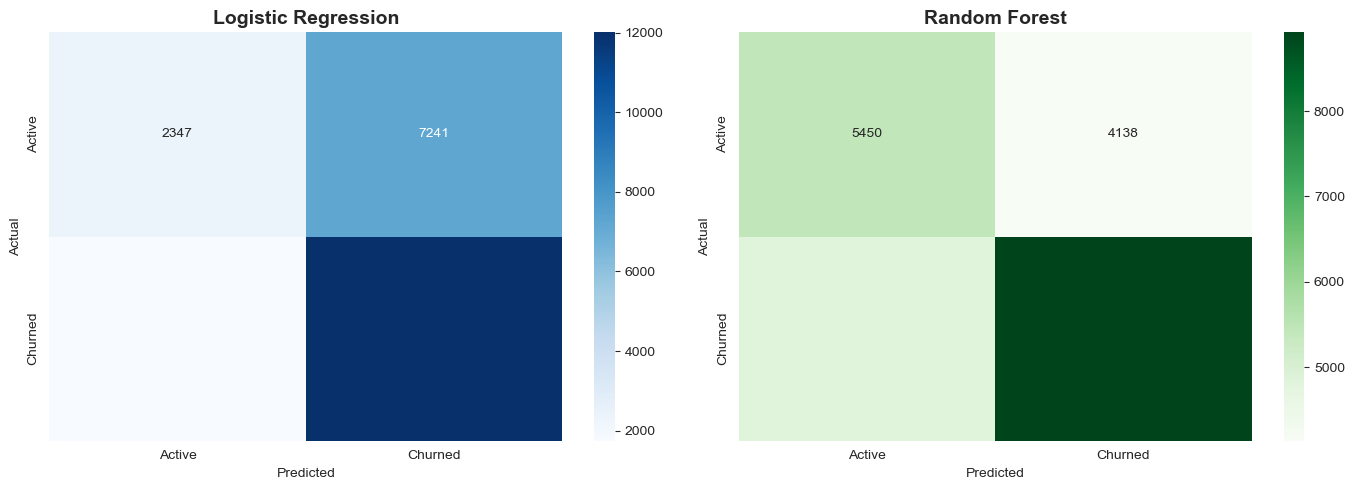

In [22]:
# confusion matrices
print("\n===== VISUALIZING CONFUSION MATRICES =====")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# logistic regression
cm_lr = confusion_matrix(Y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=ax[0],
           xticklabels=["Active", "Churned"],
           yticklabels=["Active", "Churned"])
ax[0].set_title("Logistic Regression", fontsize=14, fontweight="bold")
ax[0].set_ylabel("Actual")
ax[0].set_xlabel("Predicted")

# random forest
cm_rf = confusion_matrix(Y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=ax[1],
           xticklabels=["Active", "Churned"],
           yticklabels=["Active", "Churned"])
ax[1].set_title("Random Forest", fontsize=14, fontweight="bold")
ax[1].set_ylabel("Actual")
ax[1].set_xlabel("Predicted")

plt.tight_layout()
plt.show

# ROC Curves


===== ROC CURVES =====


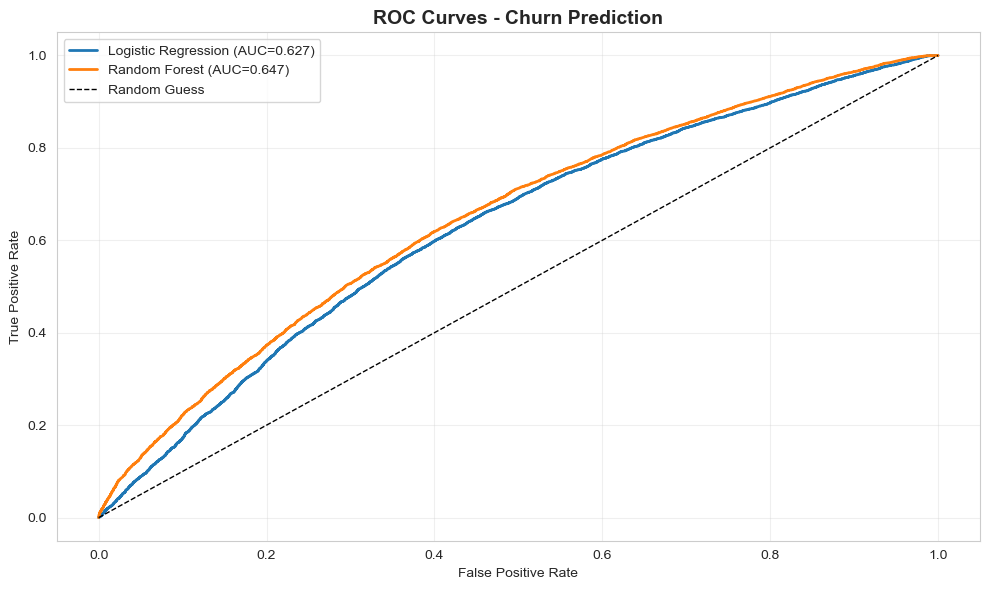

In [25]:
# ROc curves
print("\n===== ROC CURVES =====")

fig, ax = plt.subplots(figsize=(10, 6))

# logistic regression ROC
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_pred_proba)
ax.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_auc:.3f})", linewidth=2)

# random forest ROC
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_pred_proba)
ax.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={rf_auc:.3f})", linewidth=2)

# diagonal line (random guessing)
ax.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)

ax.set_title("ROC Curves - Churn Prediction", fontsize=14, fontweight="bold")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance (Random Forest)


===== FEATURE IMPORTANCE =====

Top Features for Churn Predictions:
                  feature  importance
5       avg_delivery_time    0.555957
2         avg_order_value    0.151297
1             total_spent    0.149216
6  customer_lifetime_days    0.056702
4      late_delivery_rate    0.046523
3        avg_review_score    0.030350
0            total_orders    0.009955


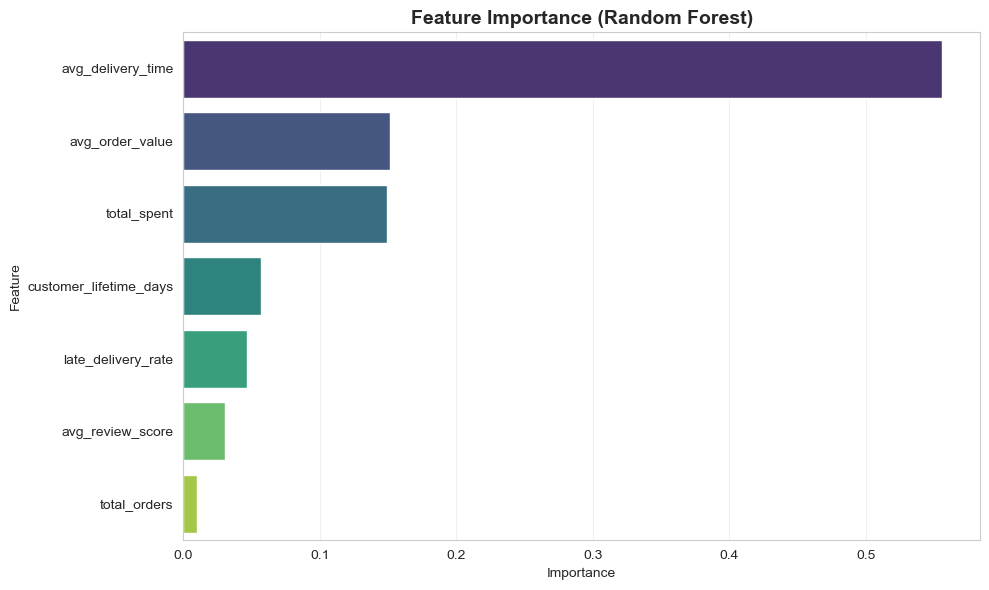

In [26]:
# feature importance
print("\n===== FEATURE IMPORTANCE =====")

# get feature importance from random forest
feature_importance = pd.DataFrame({
    "feature" : feature_cols,
    "importance" : rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Features for Churn Predictions:")
print(feature_importance)

# plot features importance
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x="importance", y="feature", palette="viridis", ax=ax)
ax.set_title("Feature Importance (Random Forest)", fontsize=14, fontweight="bold")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# Predict Churn Risk For All Customers

In [30]:
# predict churn for all customers
print("\n===== PREDICTING CHURN RISK =====")

# use random forest (better performance)
customer_metrics["churn_probability"] = rf_model.predict_proba(
    customer_metrics[feature_cols].fillna(0)
)[:, 1]

# define thresholds from model output
low_thresh = customer_metrics["churn_probability"].quantile(0.33)
high_thresh = customer_metrics["churn_probability"].quantile(0.66)

# categories risk levels
def risk_category(prob):
    if prob < low_thresh:
        return "Low Risk"
    elif prob < high_thresh:
        return "Medium Risk"
    else:
        return "High Risk"

customer_metrics["churn_risk"] = customer_metrics["churn_probability"].apply(risk_category)

# summary by risk level
risk_summary = customer_metrics.groupby("churn_risk").agg({
    "customer_unique_id": "count",
    "total_spent": "sum",
    "churn_probability": "mean"
}).reset_index()

risk_summary.columns = ["risk_level", "customers", "total_revenue", "avg_churn_prob"]
risk_summary = risk_summary.sort_values("avg_churn_prob", ascending=False)

print("\nChurn Risk Summary:")
print(risk_summary)


===== PREDICTING CHURN RISK =====

Churn Risk Summary:
    risk_level  customers  total_revenue  avg_churn_prob
0    High Risk      31742     4551228.83        0.618077
2  Medium Risk      30808     5865994.16        0.517150
1     Low Risk      30808     5002550.76        0.381620


# Identify High-Risk Customers

In [31]:
# identify high-risk customers
print("\n===== HIGH-RISK CUSTOMERS =====")

high_risk = customer_metrics[customer_metrics["churn_risk"] == "High Risk"].copy()
high_risk = high_risk.sort_values("total_spent", ascending=False)

print(f"\nHigh-risk customers: {len(high_risk):,}")
print(f"Revenue at risk: ${high_risk['total_spent'].sum():,.2f}")
print(f"Average spending (high-risk): ${high_risk['total_spent'].mean():.2f}")

print("\nTop 10 High-Risk Customers by Revenue:")
print(high_risk[["customer_unique_id", "total_spent", "total_orders", 
                 "days_since_last_order", "churn_probability"]].head(10))


===== HIGH-RISK CUSTOMERS =====

High-risk customers: 31,742
Revenue at risk: $4,551,228.83
Average spending (high-risk): $143.38

Top 10 High-Risk Customers by Revenue:
                     customer_unique_id  total_spent  total_orders  \
3724   0a0a92112bd4c708ca5fde585afaa872     13664.08             1   
79636  da122df9eeddfedc1dc1f5349a1a690c      7571.63             2   
80463  dc4802a71eae9be1dd28f5d788ceb526      6929.31             1   
23411  4007669dec559734d6f53e029e360987      6081.54             1   
87148  eebb5dda148d3893cdaf5b5ca3040ccb      4764.34             1   
87742  f0767ae738c3d90e7b737d7b8b8bb4d1      3979.55             1   
32881  59d66d72939bc9497e19d89c61a96d5f      3559.99             2   
43301  76a08544f95591acec0d4c976054c459      3358.24             1   
40567  6f00d356a4be20527662aaf12116baab      3184.55             1   
63549  ae04948ad7210ea76801b331080e0b3a      3009.53             1   

       days_since_last_order  churn_probability  
3724    

# Key Insights

In [32]:
# key insights
print("\n===== KEY INSIGHTS =====")

best_model = "Random Forest" if rf_auc > lr_auc else "Logistic Regression"
best_auc = max(rf_auc, lr_auc)

print(f"Best model: {best_model} (AUC={best_auc:.3f})")
print(f"Overall churn rate: {churn_rate:.1f}%")
print(f"High-risk customers: {len(high_risk):,} ({len(high_risk)/len(customer_metrics)*100:.1f}%)")
print(f"Revenue at risk: ${high_risk['total_spent'].sum():,.2f}")
print(f"Top predictive feature: {feature_importance.iloc[0]['feature']}")

print("\nChurn Prediction Complete!")


===== KEY INSIGHTS =====
Best model: Random Forest (AUC=0.647)
Overall churn rate: 58.9%
High-risk customers: 31,742 (34.0%)
Revenue at risk: $4,551,228.83
Top predictive feature: avg_delivery_time

Churn Prediction Complete!


# Churn Prediction - Key Insights

- **Customers analyed:** 93,358
- **Overall churn rate:** **58.9%** (no purchase in last 180 days)

---

### Model Performance Summary
Two models were evaluated for churn prediction:

| Model | ROC-AUC | Accuracy |
|-----|--------|----------|
| Logistic Regression | 0.627 | 61% |
| Random Forest | **0.647** | **62%** |

- **Random Forest performed better**, capturing non-linear relationships between customer behavior and churn.
- Logistic Regression remained useful for **interpretability**, while Random Forest was preferred for **prediction and risk scoring**.

---

### Customer Risk Segmentation
- **High Risk:** 31,742 customers → **4.55M USD revenue at risk**
- **Medium Risk:** 30,808 customers
- **Low Risk:** 30,808 customers

---

### High-Risk Customer Traits
- Long inactivity periods  
- Mostly one-time or low-frequency buyers
- High one-time spending followed by disengagement

---

### Key Churn Drivers
- Days since last order
- Purchase frequency
- Customer lifetime
- Delivery delays and delivery time

---

### Business Takeaway
- Target **high-risk customers** with re-engagement campaigns
- Use **medium-risk customers** for preventive retention
- Focus **low-risk customers** on loyalty and upselling

---

### Conclusion
The model effectively identifies churn risk and highlights significant revenue exposure, enabling targeted retention strategies.

In [ ]:
# save results
print("\n===== SAVING RESULTS =====")

customer_metrics.to_csv(
    "OneDrive/Documents/Customer Sales Analytics/customer_churn_prediction
)